# Deploy MIRA Large

A lot of the steps below are taken from [this blog post](https://aws.amazon.com/blogs/machine-learning/deploy-trained-keras-or-tensorflow-models-using-amazon-sagemaker/) which explains how to take advantage of Amazon SageMaker deployment capabilities, such as selecting the type and number of instances, performing A/B testing, and Auto Scaling. Auto Scaling clusters are spread across multiple Availability Zones to deliver high performance and high availability.

In this notebook we'll be deploying the Large MIRA model, or "Foxer", which was trained to detect larger Santa Cruz Island animals (classes are "Fox", "Skunk", "Empty"). The Keras model graph and weight files can be downloaded [here](https://github.com/tnc-ca-geo/mira/tree/master/mira_models).

### Step 1. Set up

If you're already reading this in a Sagemaker Notebook instance, just execute the code block below to get the Sagemaker execution role.

If not, and you need to set up the Sagemaker Notebook, in the AWS Management Console go to the Amazon SageMaker console. Choose Notebook Instances, and create a new notebook instance. Associate it with the animl-ml git repo (https://github.com/tnc-ca-geo/animl-ml), and set the kernel to conda_tensorflow_p36.

The ```get_execution_role``` function retrieves the AWS Identity and Access Management (IAM) role you created at the time of creating your notebook instance.

In [1]:
import boto3, re
from sagemaker import get_execution_role

role = get_execution_role()

### Step 2. Load the Keras model using the JSON and weights file

In [2]:
import keras
from keras.models import model_from_json

!mkdir keras_model

Using TensorFlow backend.



mkdir: cannot create directory ‘keras_model’: File exists


Download the json file ([FLP_Foxer_Model1.0-aug.82-0.3369-0.8745.json](https://github.com/tnc-ca-geo/mira/blob/master/mira_models/FLP_Foxer_Model1.0-aug.82-0.3369-0.8745.json)) and model weights ([FLP_Foxer_Model1.0-aug.82-0.3369-0.8745.hdf5](https://github.com/tnc-ca-geo/mira/blob/master/mira_models/FLP_Foxer_Model1.0-aug.82-0.3369-0.8745.hdf5)) from the MIRA repo mentioned above. Navigate to ```keras_model``` from the Jupyter notebook home, and upload both model.json and model-weights.h5 files (using the “Upload” menu on the Jupyter notebook home). To use a sample model for this exercise download and unzip the files found here, then upload them to keras_model.

In [3]:
!ls keras_model

json_file = open('/home/ec2-user/SageMaker/keras_model/'+'FLP_Foxer_Model1.0-aug.82-0.3369-0.8745.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

loaded_model.load_weights('/home/ec2-user/SageMaker/keras_model/FLP_Foxer_Model1.0-aug.82-0.3369-0.8745.hdf5')

print("Loaded model from disk")

FLP_Foxer_Model1.0-aug.82-0.3369-0.8745.hdf5
FLP_Foxer_Model1.0-aug.82-0.3369-0.8745.json










Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Loaded model from disk


### Step 3. Export the Keras model to the TensorFlow ProtoBuf format

In [ ]:
from tensorflow.python.saved_model import builder
from tensorflow.python.saved_model.signature_def_utils import predict_signature_def
from tensorflow.python.saved_model import tag_constants

# Note: This directory structure will need to be followed - see notes for the next section
model_version = '1'
export_dir = 'export/Servo/' + model_version

# Build the Protocol Buffer SavedModel at 'export_dir'
builder = builder.SavedModelBuilder(export_dir)

# Create prediction signature to be used by TensorFlow Serving Predict API
print('loaded_model.input: {}'.format(loaded_model.input))
print('loaded_model.output: {}'.format(loaded_model.output))
signature = predict_signature_def(
    inputs={"inputs": loaded_model.input}, outputs={"score": loaded_model.output})

from keras import backend as K

with K.get_session() as sess:
    # Save the meta graph and variables
    builder.add_meta_graph_and_variables(
        sess=sess, tags=[tag_constants.SERVING], signature_def_map={"serving_default": signature})
    builder.save()

### Step 4. Copy pre & post processing scrips into export directory

TODO: inference.py and requirements.txt will live in associated github repo - add steps for copying them into ```export/code/```. 

```inference.py``` is a pre/post processing script, and its dependencies in ```requirements.txt``` get installed in the endpoint container when it is initialized. More on that and examples [here](https://github.com/aws/sagemaker-tensorflow-serving-container#prepost-processing).

Your export directory structure should now look like this:

```
SageMaker
     ├─ deploy-mira-lrg.ipynb
     ├─ export
           └─ Servo
                 └─ 1
                       └─ saved_model.pb
                       └─ variables
                           └─ variables.data-00000-of-00001
                           └─ variables.index
           └─ code
                 └─ inference.py
                 └─ requirements.txt
```

####  Tar the entire directory and upload to S3
Yeeehaw now we're read to zip it all up and upload it to s3...

In [21]:
import tarfile
with tarfile.open('model.tar.gz', mode='w:gz') as archive:
    archive.add('export', recursive=True)

In [22]:
import sagemaker

sagemaker_session = sagemaker.Session()
inputs = sagemaker_session.upload_data(path='model.tar.gz', key_prefix='model')

### Step 3. Deploy the trained model

There are [two ways to deploy models to sagemaker](https://docs.aws.amazon.com/sagemaker/latest/dg/ex1-deploy-model.html), using the AWS Sagemaker Python SDK (what we use below), or using the AWS SDK for Python (Boto 3). Boto 3 offers more lower level configuration controls. Documentation on using the Sagemaker Python SDK for deployment can be found [here](https://sagemaker.readthedocs.io/en/stable/using_tf.html#deploy-to-a-sagemaker-endpoint). The ```model.deploy()``` function returns a predictor that you can use to test inference on right away.

TODO: 
- look into using Elastic Inference (https://docs.aws.amazon.com/sagemaker/latest/dg/ei.html) for low-cost fast inference without using a GPU instance

NOTES: Ignore the warning about python 3 and do not set the py_version argument

In [23]:
from sagemaker.tensorflow.serving import Model
sagemaker_model = Model(model_data = 's3://' + sagemaker_session.default_bucket() + '/model/model.tar.gz',
                        role = role,
                        framework_version = '1.13',
                        entry_point = 'inference.py',
                        source_dir='export/code'
                       )

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


In [24]:
%%time
predictor = sagemaker_model.deploy(initial_instance_count=1,
                                   instance_type='ml.m4.xlarge')

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


-------------!CPU times: user 731 ms, sys: 57.9 ms, total: 788 ms
Wall time: 6min 32s


### Step 4. Invoke the endpoint

Grab the newly created endpoint name from the Amazon Sagemaker Console (https://us-west-1.console.aws.amazon.com/sagemaker/home?region=us-west-1#/endpoints) and plug it in below:

In [25]:
# working endpoint (w/ inference.py)
# endpoint_name = 'tensorflow-inference-2020-11-11-20-18-02-728'

endpoint_name = 'tensorflow-inference-2020-11-12-18-15-23-021'

#### Invoke the SageMaker endpoint using a boto3 client

{'fox': 4.20286e-06, 'skunk': 0.963997, 'empty': 0.035999}


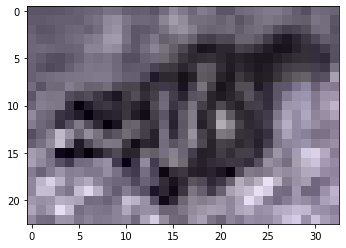

In [57]:
from matplotlib.pyplot import imshow
from io import BytesIO
import json
import boto3
import numpy as np
from PIL import Image

CLASSES = ['fox', 'skunk', 'empty']
TEST_IMG = 'input/sample-img.jpg'
TEST_MD_OUTPUT = {
    'file': 'input/sample-img.jpg',
    'detections': [{
        'category': '1',
        'conf': 0.970706,
        'bbox': [0.536007, 0.434649, 0.635773, 0.543599]
    }]
}

# TEST_IMG = 'input/sample-img-fox.jpg'
# TEST_MD_OUTPUT = {
#     'file': 'input/sample-img-fox.jpg',
#     'detections': [{
#         'category': '1',
#         'conf': 0.970706,
#         'bbox': [0.24598, 0.475871, 0.567701, 0.636399]
#     }]
# }

# TEST_IMG = 'input/sample-img-fox-2.jpg'
# TEST_MD_OUTPUT = {
#     'file': 'input/sample-img-fox-2.jpg',
#     'detections': [{
#         'category': '1',
#         'conf': 0.970706,
#         'bbox': [0.229707, 0.256563, 0.646652, 0.542365]
#     }]
# }

client = boto3.client('runtime.sagemaker')

# prep image
image = Image.open(TEST_IMG)
# imshow(np.asarray(image))

# Megadetector bbox is [ymin, xmin, ymax, xmax] in relative values
# convert to (xmin, ymin, xmax, ymax) in pixel values 
W, H = image.size
box = TEST_MD_OUTPUT['detections'][0]['bbox']
boxpx = (int(box[1]*W), int(box[0]*H), int(box[3]*W), int(box[2]*H))
crp = image.crop(boxpx)
imshow(np.asarray(crp))

# convert to bytes
buf = BytesIO()
crp.save(buf, format='JPEG')

response = client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType='application/x-image', 
    Body=buf.getvalue()
)

response_body = response['Body'].read()
response_body = response_body.decode('utf-8')
pred = json.loads(response_body)["predictions"][0]

output = {}
for i in range(len(pred)): output[CLASSES[i]] = float(pred[i])
    
print(output)

